## what are we trying to do
a graph with 2 agents. one that writes an article plan from a raw interview with an expert 
another agent that writes the blogpost from the plan 
## next steps (later)
try to add interrupt
and human feedback 


In [25]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [26]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

In [27]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "meetup_writing_agent"

In [28]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Plan(BaseModel):
    who: str = Field(
        description="target reader of the blog post, e.g., 'AI researchers', 'business leaders', etc.",
    )
    why: str = Field(
        description="why are we writing this blog post.",
    )
    what: str = Field(
        description="what are the main topics to cover in the blog post.",
    )
    the_issue: str = Field(
        description="the main issue or problem that the blog post addresses.",
    )
    where_we_stand: str = Field(
        description="current position or perspective on the issue.",
    )
    single_message: str = Field(
        description="the single most important message to convey in the blog post.",
    )

    @property
    def plan(self) -> str:
        return (
            f"Who: {self.who}\n"
            f"Why: {self.why}\n"
            f"What: {self.what}\n"
            f"Issue: {self.the_issue}\n"
            f"Where We Stand: {self.where_we_stand}\n"
            f"Single Message: {self.single_message}\n"
        )

class Perspectives(BaseModel):
    plan: List[Plan] = Field(
        description="AI generated plan / scaffold for the blog post.",
    )

class BlogPost(BaseModel):
    title: str = Field(description="The title of the blog post.")
    content: str = Field(description="The full content of the blog post.")

    
class GenerateBlogState(TypedDict):
    company_strategy: str  # Company strategy
    content_strategy: str      # content strategy
    plan: List[Plan]       # AI generated plan / scaffold for the blog post.
    human_analyst_feedback: str # Human feedback
    blog_post: List[BlogPost]  # the substance of the blog posts, with a {"title": str, "content": str} written according to the plan.

In [29]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

plan_instructions = """You are tasked with creating a plan for a proffesional blog post for a company called Big Kids Automation Agency. the plan is just a skeleton of a blog post which contains
some question and answers that will help the company writer to write a focused blog post. this plan is a set of instruction to the writer to stay focus and write the post. 
 
The raw_input is a transcript of a conversation with an expert.  i want you to use this input as the basis for the plan of the blog post. you take this
as the source where you will extract the ideas for the blog post.

Follow these instructions carefully:

1. First, review the company business strategy. Examine the company strategy:
{company_strategy}
        
2. The blog post must fit the company content strategy. Examine the company content strategy: 
        
{content_strategy}

3. Read the raw_imput.
    {raw_input}
4. Create a plan for a blog post. The plan should include the following sections:

who , why, what, the_issue, where_we_stand, single_message.

5. Examine any editoral feedback from the human analyst. If there is any feedback, incorporate it into the plan. 
{human_analyst_feedback}


                    
"""

In [30]:
from pathlib import Path

raw_input_path = Path("data/processed/raw_input.mkd")
company_strategy_path = Path("data/processed/company_strategy.mkd")
content_strategy_path = Path("data/processed/content_strategy.mkd")


In [31]:
def create_plan(state: GenerateBlogState):
    """Create plan"""
    company_strategy = state['company_strategy']
    content_strategy = state['content_strategy']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    
    # Read the company strategy
    try:
        with open("company_strategy_path", "r", encoding="utf-8") as f:
            company_strategy = f.read()
    except FileNotFoundError:
        raw_input = "No raw input file found."
    
    # Read the content strategy
    try:
        with open("content_strategy_path", "r", encoding="utf-8") as f:
            content_strategy = f.read()
    except FileNotFoundError:
        raw_input = "No raw input file found."
    
    # Read raw_input file
    try:
        with open("raw_input_path", "r", encoding="utf-8") as f:
            raw_input = f.read()
    except FileNotFoundError:
        raw_input = "No raw input file found."

    

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = plan_instructions.format(
        company_strategy=company_strategy,
        human_analyst_feedback=human_analyst_feedback,
        content_strategy=content_strategy,
        raw_input=raw_input
    )

    # Generate question 
    plan = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the article plan.")])
    
    # Write the plan to the state
    return {"plan": plan.plan}

def human_feedback(state: GeneratePlanState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GeneratePlanState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_plan"
    
    # Otherwise end
    return END
   
def write_blog_post(state: GenerateBlogState):
    """Generate a blog post draft from the plan."""
    
    blog_post_instructions = (
        "You are a professional blog writer for Big Kids Automation Agency. "
        "Using the following plan, write a complete blog post. "
        f'Plan: {state["plan"]}\n'

        "Make sure the post is engaging, clear, and follows the structure and intent of the plan. "
        "Return a title and the full content of the blog post.\n\n"
    )

    structured_llm = llm.with_structured_output(BlogPost)
    blog_post = structured_llm.invoke([SystemMessage(content=blog_post_instructions), HumanMessage(content="Write the blog post.")])
    # Return the blog_post as part of the state
    return {"blog_post": [blog_post]}

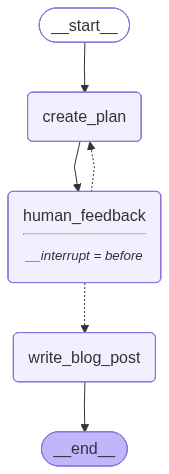

In [33]:
# Add nodes and edges 
builder = StateGraph(GenerateBlogState)
builder.add_node("create_plan", create_plan)
builder.add_node("human_feedback", human_feedback)
builder.add_node("write_blog_post", write_blog_post)

builder.add_edge(START, "create_plan")
builder.add_edge("create_plan", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_plan", "write_blog_post"])
builder.add_edge("write_blog_post", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)


# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [34]:
# Input
thread = {"configurable": {"thread_id": "2"}}

try:
    for event in graph.stream({"company_strategy": company_strategy, "content_strategy": content_strategy}, thread, stream_mode="values"):
        # Review
        plan = event.get('plan', '')
        blog_post = event.get('blog_post', None)
        
        if plan:
            print("=== PLAN GENERATED ===")
            for p in plan:
                print(f"Who: {p.who}")
                print(f"Why: {p.why}")
                print(f"What: {p.what}")
                print(f"Issue: {p.the_issue}")
                print(f"Where We Stand: {p.where_we_stand}")
                print(f"Single Message: {p.single_message}")
                print("-" * 50)
        
        if blog_post:
            print("=== BLOG POST GENERATED ===")
            if isinstance(blog_post, list) and blog_post:
                post = blog_post[0]
                print("Title:", post.title)
                print("\nContent:\n", post.content)
            elif hasattr(blog_post, 'title'):
                print("Title:", blog_post.title)
                print("\nContent:\n", blog_post.content)
            print("=== GENERATION COMPLETE ===")
            
except Exception as e:
    print(f"Error during graph execution: {e}")
    # Check the current state
    state = graph.get_state(thread)
    print(f"Current state keys: {state.values.keys() if state.values else 'No state'}")
    print(f"Next node: {state.next}")

=== PLAN GENERATED ===
Who: SME owners and managers
Why: To educate SME owners and managers on the transformative potential of AI and automation in improving business efficiency and employee satisfaction.
What: The blog post will cover the benefits of AI and automation for SMEs, how these technologies can save time and money, enhance employee happiness, and improve tech understanding. It will also discuss the agency's approach to automation and the importance of a healthier interdependence with tech tools.
Issue: Many SMEs struggle with inefficient processes and a lack of understanding of how to leverage AI and automation to improve their operations.
Where We Stand: Big Kids Automation Agency believes in promoting a healthier interdependence with tech tools, freeing up time for SMEs through process automation, and liberating time through AI for SMEs.
Single Message: AI and automation can transform SMEs by saving time, reducing costs, and enhancing employee satisfaction, leading to a he

In [35]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [36]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": 
                            "please include a reference to security issues"}, as_node="human_feedback")

KeyError: '__end__'